## Submodule-2.1 : Dynamical Systems

## Table of Contents
#### 1. [PINN for Burger's Equation in TensorFlow](#PINN-for-Burger's-Equation-in-TensorFlow)
#### 2. [PINN for Burger's Equation in JAX](#PINN-for-Burger's-Equation-in-JAX)
#### 3. [PINN for a Boundary Layer Problem](#PINN-for-a-Boundary-Layer-Problem)
#### 4. [Neural Network with Hard Constraints](#Neural-Network-with-Hard-Constraints)


## PINN-for-Burger's-Equation

In [1]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

/Users/raj/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x, t, w, b):
    u = DNN(tf.concat([x,t],1), w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,t,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x, t])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x, t])
            u=net_u(x,t, W, b)
        u_t = tape2.gradient(u, t)
        u_x = tape2.gradient(u, x)
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_t + u*u_x - nu*u_xx
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu):
    x_u = X_u_train_tf[:,0:1]
    t_u = X_u_train_tf[:,1:2]
    x_f = X_f_train_tf[:,0:1]
    t_f = X_f_train_tf[:,1:2]
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u, t_u, W, b) 
        f_nn = net_f(x_f,t_f, W, b, nu)
        loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf)) + tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss


    
nu = 0.01/np.pi
noise = 0.0        
N_u = 100
N_f = 10000
Nmax=20000

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

data = scipy.io.loadmat('./Data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              
# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)

lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

    

Iteration is: 0 and loss is: 0.2566310167312622
Iteration is: 1 and loss is: 0.23526228964328766
Iteration is: 2 and loss is: 0.22125136852264404
Iteration is: 3 and loss is: 0.2152591347694397
Iteration is: 4 and loss is: 0.21643051505088806
Iteration is: 5 and loss is: 0.22051557898521423
Iteration is: 6 and loss is: 0.22254502773284912
Iteration is: 7 and loss is: 0.22123509645462036
Iteration is: 8 and loss is: 0.2179287075996399
Iteration is: 9 and loss is: 0.21430082619190216
Iteration is: 10 and loss is: 0.21143503487110138
Iteration is: 11 and loss is: 0.2097298800945282
Iteration is: 12 and loss is: 0.20907731354236603
Iteration is: 13 and loss is: 0.20907141268253326
Iteration is: 14 and loss is: 0.20919497311115265
Iteration is: 15 and loss is: 0.2089935839176178
Iteration is: 16 and loss is: 0.20821210741996765
Iteration is: 17 and loss is: 0.2068447321653366
Iteration is: 18 and loss is: 0.20509067177772522
Iteration is: 19 and loss is: 0.2032514214515686
Iteration is: 20 

Error u: 6.463021e-01


Text(0.5, 1.0, '$t = 0.75$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


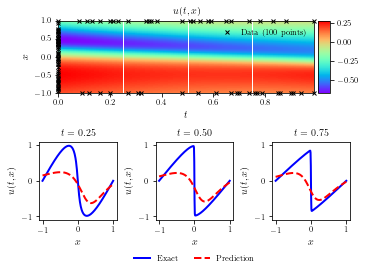

In [3]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf[:,0:1]
    t_star = X_star_tf[:,1:2]
    u_pred = net_u(x_star, t_star, w, b)
    return u_pred
    
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     
U_pred = griddata(X_star, u_pred.numpy().flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)


fig, ax = newfig(1.0, 1.1)
ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)
#ax.plot(X_f_train[0:100,1], X_f_train[0:100,0], 'bx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

In [ ]:
loss[0]

In [ ]:
it = np.arange(0,40001, 1)
loss_list = [loss[i].numpy() for i in range(0,40001)]
plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Exact')       
plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')    
plt.show()

## PINN-for-Burger's-Equation-in-JAX

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import scipy.io
from pyDOE import lhs
from jax.nn import tanh, relu
import sys
from jax.example_libraries import optimizers
from tqdm import trange
sys.path.insert(0, 'Utilities/')
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
def random_layer_params(m, n, key, scale):
    w_key, b_key = random.split(key)
    return scale*random.normal(w_key, (m, n)), jnp.zeros(n)

def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, 2.0/(jnp.sqrt(m+n))) \
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


@jit
def predict(params, X, lb, ub):
    H =  2.0*(X - lb)/(ub - lb) - 1.0
    for w, b in params[:-1]:
        H = tanh(jnp.dot(H, w) + b)
        final_w, final_b = params[-1]
    H = jnp.dot(H, final_w) + final_b
    return H


@jit
def net_u(params, x, t, lb, ub):
    x_con =jnp.array([x, t])
    y_pred = predict(params, x_con, lb, ub)
    return y_pred

@jit
def net_u_grad(params, x, t, lb, ub):
    x_con =jnp.array([x, t])
    y_pred = predict(params, x_con, lb, ub)
    return y_pred[0]

def net_f(params, lb, ub):
    def u_t(x, t):
        ut = grad(net_u_grad, argnums=2)(params, x, t, lb, ub) 
        return ut

    def u_x(x, t):
        ux = grad(net_u_grad, argnums=1)(params, x, t, lb, ub) 
        return ux   
    return jit(u_t), jit(u_x)


def net_fxx(params, lb, ub):
    def u_xx(x, t):
        _, u_x = net_f(params, lb, ub) 
        ux = grad(u_x, argnums=0)(x, t) 
        return ux   
    return jit(u_xx)


@jit
def loss_data(params,x,t, lb, ub, u_train):
    u_pred = vmap(net_u, (None, 0, 0, None, None))(params, x, t, lb, ub)
    loss = jnp.mean((u_pred - u_train)**2 )
    return loss

@jit
def loss_f(params, x, t, lb, ub, nu):
    u = vmap(net_u, (None, 0, 0, None, None))(params, x, t, lb, ub)
    u_tf, u_xf = net_f(params, lb, ub)
    u_xxf = net_fxx(params, lb, ub)
    u_t = vmap(u_tf, (0, 0))(x, t)
    u_x = vmap(u_xf, (0, 0))(x, t)
    u_xx = vmap(u_xxf, (0, 0))(x, t)
    res = u_t + u.flatten() * u_x - nu * u_xx 
    loss_f = jnp.mean((res.flatten())**2)
    return loss_f

@jit
def predict_u(params, x_star, t_star, lb, ub):
    u_pred = vmap(net_u, (None, 0, 0, None, None))\
    (params, x_star, t_star, lb, ub)
    return u_pred

def loss_fn(params, x_f, t_f,x_d, t_d, lb, ub, nu, y_d):
    loss_res = loss_f(params, x_f, t_f, lb, ub, nu)
    data_loss = loss_data(params, x_d, t_d, lb, ub, y_d) 
    return loss_res + data_loss

@jit
def step(istep, opt_state, t_d, x_d, y_d, t_f, x_f, lb, ub):
    param = get_params(opt_state) 
    g = grad(loss_fn, argnums=0)(param, x_f, t_f,x_d, t_d, lb, ub, nu, y_d)
    return opt_update(istep, g, opt_state)

if __name__ == "__main__":
    nu = 0.01/np.pi
    N_u = 100
    N_f = 10000
    layers = [2, 20, 20, 20, 20, 20, 20, 20,20, 20, 1]
    data = scipy.io.loadmat('Data/burgers_shock.mat')
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = np.real(data['usol']).T    
    X, T = np.meshgrid(x,t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.flatten()[:,None]              
    lb = X_star.min(0)
    ub = X_star.max(0)
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    uu1 = Exact[0:1,:].T
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    uu2 = Exact[:,0:1]
    xx3 = np.hstack((X[:,-1:], T[:,-1:]))
    uu3 = Exact[:,-1:]
    X_u_train = np.vstack([xx1, xx2, xx3])
    X_f_train = lb + (ub-lb)*lhs(2, N_f)
    X_f_train = np.vstack((X_f_train, X_u_train))
    u_train = np.vstack([uu1, uu2, uu3])
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    X_u_train = X_u_train[idx, :]
    u_train = u_train[idx,:]
    x_d = X_u_train[:, 0]
    t_d = X_u_train[:, 1]
    x_f = X_f_train[:, 0]
    t_f = X_f_train[:, 1]
    x_star = X_star[:, 0]
    t_star = X_star[:, 1]
    params = init_network_params(layers, random.PRNGKey(1234))
    opt_init, opt_update, get_params = optimizers.adam(5e-4)
    opt_state = opt_init(params)
    nIter = 20000 + 1
    ld_list = []
    lf_list = []
    pbar = trange(nIter)
    
    for it in pbar:
        opt_state = step(it, opt_state, t_d, x_d, u_train, t_f, x_f, lb, ub)
        if it % 1 == 0:
            params = get_params(opt_state)
            l_d = loss_data(params, x_d, t_d, lb, ub, u_train)
            l_f = loss_f(params, x_f, t_f, lb, ub, nu)
            pbar.set_postfix({'Loss': l_d, 'loss_physics': l_f})
            ld_list.append(l_d)
            lf_list.append(l_f)


    u_pred = predict_u(params, x_star, t_star, lb, ub)
            
    error_u = jnp.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    print('Error u: %e' % (error_u))
    np.save("ld_list.npy", np.array(ld_list), allow_pickle=True) 
    np.save("lf_list.npy", np.array(lf_list), allow_pickle=True)  
 
    
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    Error = np.abs(Exact - U_pred)
    
    fig, ax = newfig(1.0, 1.1)
    ax.axis('off')
    
    ####### Row 0: u(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)
    
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(t,x)$', fontsize = 10)
    
    ####### Row 1: u(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = 0.25$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75$', fontsize = 10)

    savefig("Burgers")
    


## PINN-for-a-Boundary-Layer-Problem

In [ ]:
### Solution of Equation using Central Finite Difference Equation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
%matplotlib inline
matplotlib.rc('font', family='serif', serif='cm10')

matplotlib.rc('text', usetex=True)
### Number of Gridpoints
nu =1.0/10**-3
n = 100
h = (1+1) / n
x = np.linspace(-1,1,n+1)
# Difference Operator
A = np.zeros((n+1, n+1))

## Coefficient For Boundary Condition
A[0, 0] = 1
A[n, n] = 1

### Maric for Interior Point
for i in range(1, n):
    A[i, i-1] = 1
    A[i, i] = -(2 + (nu)*h**2)
    A[i, i+1] = 1

# Get b
b = np.zeros(n+1)
b = (np.exp(x))*h*h*(nu)

#### Imposition Boundary Condition 
b[0] = 1
b[-1] = 0
# solve the linear equations
y_act = np.linalg.solve(A, b)
### Plot of Equation
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
ax.plot(x, y_act, "-", lw=2.0, color="b")
ax.set_xlabel('$x$')
ax.set_ylabel("$u$")
plt.show()

In [ ]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu):
    x_u = X_u_train_tf
    x_f = X_f_train_tf
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u, W, b) 
        f_nn = net_f(x_f,W, b, nu)
        loss =  100.0*tf.reduce_mean(tf.square(u_nn - u_train_tf)) + tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss

def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**3
noise = 0.0        
N_f = 300
Nmax=3000

layers = [1, 4,4,4,4,4,4, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)


lr = 5e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

In [ ]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,loss_list, 'g-', linewidth = 2)       
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()





In [ ]:
##Self Adaptive for residual minimzation


import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars_nn(W, b):
    return W + b

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def train_vars_sa(lambda_r, lambda_b):
    return lambda_r + lambda_b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    return alpha_r, alpha_b


#@tf.function(jit_compile=True)
@tf.function
def net_f(x, W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f

@tf.function
def net_fd(x, W, b, nu):
    h=0.1
    u_xx= (1/(h**2))*(net_u(x + h , W, b) - net_u(x, W, b) + net_u(x-h, W, b))
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu, lambda_r, lambda_b):
    x_u = X_u_train_tf
    x_f = X_f_train_tf
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b,lambda_r,lambda_b])
        u_nn = net_u(x_u, W, b) 
        f_nn = net_f(x_f,W, b, nu)
        loss_r = tf.square(lambda_r*f_nn)
        loss_b = tf.square(lambda_b*(u_nn-u_train_tf))
        loss =    tf.reduce_mean(loss_b) + tf.reduce_mean(loss_r)  
    grads = tape.gradient(loss, train_vars_nn(W, b))
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    opt.apply_gradients(zip(grads, train_vars_nn(W,b)))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    return loss

def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**-3
Nmax= 3000
N_f = 500
N_b = 2

layers = [1, 8, 8, 8,8,8,8, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

alpha_r, alpha_b = loss_weight(N_f, N_b)

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)


lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu, alpha_r, alpha_b)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))


In [ ]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,loss_list/(np.max(loss_list)), 'g-', linewidth = 2)       
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()



In [ ]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f

@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f






#@tf.function(jit_compile=True)
@tf.function
def train_step(layers, W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu, lambda_b, beta):
    x_u = X_u_train_tf[:,0:1]
    x_f = X_f_train_tf[:,0:1]
    adpative_constant_bcs_list = []
    lambda_b_list = []
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u,W, b) 
        f_nn = net_f(x_f,W, b, nu)
        bc_loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf))
        phys_loss = tf.reduce_mean(tf.square(f_nn)) 
        loss = lambda_b[-1]*bc_loss  + phys_loss
        loss = loss / (1 + lambda_b[-1])
        p_loss = phys_loss/(1 + lambda_b[-1])
        b_loss = lambda_b[-1]*bc_loss/(1 + lambda_b[-1])
    grad_loss = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grad_loss, train_vars(W,b)))
    grads_bc = tape.gradient(bc_loss, train_vars(W,b))
    grads_phys = tape.gradient(phys_loss, train_vars(W,b))
    for i in range(len(layers) - 1):
        adpative_constant_bcs_list.append(
                tf.reduce_mean(tf.abs(grads_phys[i])) / tf.reduce_mean(tf.abs(grads_bc[i])))
        
    lambda_b_new = tf.reduce_mean(tf.stack(adpative_constant_bcs_list))
    lambda_b_new = (1-beta)*lambda_b[-1] + beta*lambda_b_new
    lambda_b_list.append(lambda_b_new)
                                      
    return loss, lambda_b_list, p_loss, b_loss


def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**-3
noise = 0.0        
N_f = 500
Nmax=50000

layers = [1, 8,8,8,8,8,8, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])
X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))
X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)
lam_b = np.array([1.0])
lam_b_tf= tf.convert_to_tensor(lam_b, dtype=tf.float32)                                
lambda_b_list = [lam_b_tf]                               
lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)
start_time = time.time()
n=0
loss = []
bc_loss = []
phys_loss = []
beta = 0.1

while n <= Nmax:
    loss_, lambda_b_out, phys_loss_, bc_loss_ = train_step(layers, W, b, X_u_train_tf,\
                                                u_train_tf, X_f_train_tf, optimizer, nu,lambda_b_list, beta)
    lambda_b_list = lambda_b_out
    loss.append(loss_) 
    bc_loss.append(bc_loss_)
    phys_loss.append(phys_loss_)
    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))               
print('Training time: %.4f' % (elapsed))


def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]
bc_loss_list = [bc_loss[i].numpy() for i in range(len(bc_loss))]
phys_loss_list = [phys_loss[i].numpy() for i in range(len(phys_loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,bc_loss_list, 'g-', linewidth = 2, label="Boundary Loss")   
ax.semilogy(ep,phys_loss_list, 'r-', linewidth = 2, label="Residual Loss")
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()


In [ ]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]
bc_loss_list = [bc_loss[i].numpy() for i in range(len(bc_loss))]
phys_loss_list = [phys_loss[i].numpy() for i in range(len(phys_loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep, bc_loss_list, 'g-', linewidth = 2, label="Boundary Loss")   
ax.semilogy(ep,phys_loss_list, 'r-', linewidth = 2, label="Residual Loss")
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()

plt.show()


In [ ]:
#https://github.com/jnh277/Linearly-Constrained-NN/blob/release/simulted_divergence_free.py

import torch
from matplotlib import pyplot as plt
from torch.utils import data
import numpy as np
import torch.autograd as ag
import torch.nn as nn
torch.manual_seed(1234)
epochs = 400
n_data = 200
### Input Data
def vector_field(x, y, a=0.01):
    v1 = torch.exp(-a*x*y)*(a*x*torch.sin(x*y) - x*torch.cos(x*y))
    v2 = torch.exp(-a*x*y)*(y*torch.cos(x*y) - a*y*torch.sin(x*y))
    return (v1, v2)


## ------------------ set up models-------------------------- ##
# set network size
n_in = 2
n_h1 = 100
n_h2 = 50
n_o = 1

# two outputs for the unconstrained network
n_o_uc = 2

# define model class
class DivFree2D(torch.nn.Module):
    def __init__(self, base_net):
        super(DivFree2D, self).__init__()
        self.base_net = base_net

    def forward(self, x):
        x.requires_grad = True
        y = self.base_net(x)
        dydx = ag.grad(outputs=y, inputs=x, create_graph=True, grad_outputs=torch.ones(y.size()),
                       retain_graph=True, only_inputs=True)[0]
        return y, dydx[:,1].unsqueeze(1), -dydx[:,0].unsqueeze(1)

model = DivFree2D(nn.Sequential(nn.Linear(n_in,n_h1),nn.Tanh(),nn.Linear(n_h1,n_h2),
                                         nn.Tanh(),nn.Linear(n_h2,n_o)))


model_uc = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h1, n_h2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h2, n_o_uc),
)


# pregenerate validation data
x_val = 4.0 * torch.rand(2000, 2)
x1_val = x_val[:, 0].unsqueeze(1)
x2_val = x_val[:, 1].unsqueeze(1)

(v1, v2) = vector_field(x1_val, x2_val)
y1_val = v1 + 0.1 * torch.randn(x1_val.size())
y2_val = v2 + 0.1 * torch.randn(x1_val.size())
y_val = torch.cat((y1_val, y2_val), 1)


# Get the true function values on a grid
xv, yv = torch.meshgrid([torch.arange(0.0, 20.0) * 4.0 / 20.0, torch.arange(0.0, 20.0) * 4.0 / 20.0])
(v1, v2) = vector_field(xv, yv)

# generate training data
x_train = 4.0 * torch.rand(n_data, 2)
x1_train = x_train[:, 0].unsqueeze(1)
x2_train = x_train[:, 1].unsqueeze(1)

(v1_t, v2_t) = vector_field(x1_train, x2_train)
y1_train = v1_t + 0.1 * torch.randn(x1_train.size())
y2_train = v2_t + 0.1 * torch.randn(x1_train.size())


# define Dataset class
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, x1, x2, y1, y2):
        'Initialization'
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x1)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x1 = self.x1[index]
        x2 = self.x2[index]
        y1 = self.y1[index]
        y2 = self.y2[index]

        return x1, x2, y1, y2

training_set = Dataset(x1_train, x2_train, y1_train, y2_train)

# data loader Parameters
DL_params = {'batch_size': 100,
             'shuffle': True,
             'num_workers': 0,
             'pin_memory': False}
training_generator = data.DataLoader(training_set, **DL_params)


# ---------------  Set up and train the constrained model -------------------------------
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau\
                                    (optimizer, patience=10,
                                     min_lr=1e-10,
                                     factor=0.5, cooldown=15)

def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        (yhat, v1hat, v2hat) = model(x_train)
        loss = (criterion(y1_train, v1hat) + criterion(y2_train, v2hat)) / 2  # divide by 2 as it is a mean
        loss.backward()
        optimizer.step()
        total_loss += loss
        n_batches += 1
    return total_loss / n_batches

def eval(epoch):
    model.eval()
    # with torch.no_grad():
    (yhat, v1hat, v2hat) = model(x_val)
    loss = (criterion(y1_val, v1hat) + criterion(y2_val, v2hat)) / 2
    return loss.cpu()


train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])

print('Training Constrained NN')

for epoch in range(epochs):
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    print('Constrained NN: epoch: ', epoch, 'training loss ', train_loss[epoch], \
          'validation loss', val_loss[epoch])


# work out the rms error for this one
x_pred = torch.cat((xv.reshape(20 * 20, 1), yv.reshape(20 * 20, 1)), 1)
(f_pred, v1_pred, v2_pred) = model(x_pred)
error_new = torch.cat((v1.reshape(400, 1) - v1_pred.detach(), v2.reshape(400, 1) - v2_pred.detach()), 0)
rms_error = torch.sqrt(sum(error_new * error_new) / 800)

# ---------------  Set up and train the uncconstrained model -------------------------------
optimizer_uc = torch.optim.Adam(model_uc.parameters(), lr=0.01)
scheduler_uc = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_uc, patience=10,
                                                     min_lr=1e-10,
                                                    factor=0.5,
                                                    cooldown=15)

def train_uc(epoch):
    model_uc.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer_uc.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        vhat = model_uc(x_train)
        y_train = torch.cat((y1_train, y2_train), 1)
        loss = criterion(y_train, vhat)
        loss.backward()
        optimizer_uc.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

def eval_uc(epoch):
    model_uc.eval()
    with torch.no_grad():
        (vhat) = model_uc(x_val)
        loss = criterion(y_val, vhat)
    return loss.cpu()


train_loss_uc = np.empty([epochs, 1])
val_loss_uc = np.empty([epochs, 1])


print('Training standard NN')

for epoch in range(epochs):
    train_loss_uc[epoch] = train_uc(epoch).detach().numpy()
    v_loss = eval_uc(epoch)
    scheduler_uc.step(v_loss)
    val_loss_uc[epoch] = v_loss.detach().numpy()
    print('Standard NN: epoch: ', epoch, 'training loss ', \
          train_loss_uc[epoch], 'validation loss', val_loss_uc[epoch])


# work out final rms error for unconstrainted net
(v_pred_uc) = model_uc(x_pred)
v1_pred_uc = v_pred_uc[:, 0]
v2_pred_uc = v_pred_uc[:, 1]

error_uc = torch.cat((v1.reshape(400) - v1_pred_uc.detach(), v2.reshape(400) - v2_pred_uc.detach()), 0)
rms_uc = torch.sqrt(sum(error_uc * error_uc) / 800)



print('Finished')
print("Final RMSE for constrained neural network: ",rms_error.item())
print("Final RMSE for standard neural network: ",rms_uc.item())

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 2, figsize=(20, 16))
    # ax.pcolor(xv,yv,f_scalar)
    ax[0, 0].quiver(xv, yv, v1, v2)
    ax[0, 0].quiver(xv, yv, v1_pred.reshape(20, 20).detach(), v2_pred.reshape(20, 20).detach(), color='r')
    ax[0, 0].legend(['true', 'predicted'], fontsize=22)
    ax[0, 0].set_title('Constrained NN ', fontsize=22)
    ax[0, 0].tick_params(axis='x', labelsize=14 )
    ax[0, 0].tick_params(axis='y', labelsize=14 )


    ax[1, 0].plot(np.log(train_loss),lw=3.0)
    ax[1, 0].plot(np.log(val_loss), lw=3.0)
    # ax[1].plot(loss_save[1:epoch].log().detach().numpy())
    ax[1, 0].set_xlabel('training epoch',  fontsize=22)
    ax[1, 0].set_ylabel('Loss',  fontsize=22)
    ax[1, 0].legend(['training loss', 'val loss'], fontsize=22)
    ax[1, 0].tick_params(axis='x', labelsize=14 )
    ax[1, 0].tick_params(axis='y', labelsize=14 )

    ax[0, 1].quiver(xv, yv, v1, v2)
    ax[0, 1].quiver(xv, yv, v1_pred_uc.reshape(20, 20).detach(), v2_pred_uc.reshape(20, 20).detach(), color='r')
    ax[0, 1].legend(['true', 'predicted'], fontsize=22)
    ax[0, 1].set_title('Standard NN ',fontsize=22)
    ax[0, 1].tick_params(axis='x', labelsize=14 )
    ax[0,1].tick_params(axis='y', labelsize=14 )

    ax[1, 1].plot(np.log(train_loss_uc),lw=3.0)
    ax[1, 1].plot(np.log(val_loss_uc),lw=3.0)
    ax[1, 1].set_ylabel('Loss', fontsize=22)
    ax[1, 1].set_xlabel('training epoch', fontsize=22)
    ax[1, 1].legend(['training loss','val loss'], fontsize=22)
    ax[1, 1].tick_params(axis='x', labelsize=14)
    ax[1,1].tick_params(axis='y', labelsize=14 )
    plt.savefig("Figure_1.png", dpi=300)
    plt.show()
   
    

    # Initialize second plot
    f2, ax2 = plt.subplots(1, 3, figsize=(48, 10))
    Q = ax2[0].quiver(xv, yv, v1, v2, scale=None, scale_units='inches')
    Q._init()
    assert isinstance(Q.scale, float)
    ax2[0].quiver(x1_train, x2_train, y1_train, y2_train, scale=Q.scale, scale_units='inches', color='r')
    ax2[0].set_xlabel('$x_1$')
    ax2[0].set_ylabel('$x_2$')
    ax2[0].tick_params(axis='x', labelsize=36)
    ax2[0].tick_params(axis='y', labelsize=36)
    


    error_new = torch.cat((v1.reshape(400, 1) - v1_pred.detach(), v2.reshape(400, 1) - v2_pred.detach()), 0)
    rms_new = torch.sqrt(sum(error_new * error_new) / 800)

    ax2[1].quiver(xv, yv, v1 - v1_pred.reshape(20, 20).detach(), v2 - v2_pred.reshape(20, 20).detach(),
                  scale=Q.scale, scale_units='inches')
    ax2[1].set_xlabel('$x_1$')
    ax2[1].set_ylabel('$x_2$')
    ax2[1].set_title('Constrained Approach RMSE={0:.2f}'.format(rms_new.item()), fontsize=36)
    ax2[1].tick_params(axis='x', labelsize=36 )
    ax2[1].tick_params(axis='y', labelsize=36 )
    


    error_uc = torch.cat((v1.reshape(400) - v1_pred_uc.detach(), v2.reshape(400) - v2_pred_uc.detach()), 0)
    rms_uc = torch.sqrt(sum(error_uc * error_uc) / 800)

    ax2[2].quiver(xv, yv, v1 - v1_pred_uc.reshape(20, 20).detach(), v2 - v2_pred_uc.reshape(20, 20).detach(),
                  scale=Q.scale, scale_units='inches')
    ax2[2].set_xlabel('$x_1$')
    ax2[2].set_ylabel('$x_2$')
    ax2[2].set_title('Unconstrained NN RMSE={0:.2f}'.format(rms_uc.item()), fontsize=36)
    ax2[2].tick_params(axis='x', labelsize=36 )
    ax2[2].tick_params(axis='y', labelsize=36 )
    plt.savefig("Figure_2.png", dpi=300)
    plt.show()
